# Experiment 1

How well do TPMS scores predict bids?

The deliverable will be a plot showing the performance of the TPMS scores on the "recall@M" evaluation metric.

Plan:
- load eval data for UAI 18 conference
- load a model (which could be pre-trained, if the model requires training)
- evaluate the model and produce graphs

In [25]:
%load_ext autoreload
%autoreload 2

import os, sys

import json, csv
import itertools

import openreview
import numpy
sys.path.append('..')
from collections import defaultdict
from expertise.models import tfidf, randomize, model_utils

## Data


Load up data and organize it into various indices

In [4]:
data_dir = '../data/uai18/'

submission_records_dir = os.path.join(data_dir, 'submission_records_fulltext')
reviewer_archives_dir = os.path.join(data_dir, 'reviewer_archives')
reviewer_bids_file = os.path.join(data_dir, 'reviewer_bids.jsonl')
tfidf_scores_file = os.path.join(data_dir, 'tfidf-score-matrix.txt')
tpms_scores_file = os.path.join(data_dir,'tpms-score-matrix.txt')
random_scores_file = os.path.join(data_dir, 'random-score-matrix.txt')

papers = []
for filename in os.listdir(submission_records_dir):
    with open(os.path.join(submission_records_dir, filename)) as f:
        papers.append(openreview.Note(**json.load(f)))
        
paper_by_number = {n.number: n for n in papers}

In [5]:
reviewer_ids = []
for filename in os.listdir(reviewer_archives_dir):
    reviewer_ids.append(filename.replace('.jsonl',''))

In [6]:
all_bids = []

with open(reviewer_bids_file) as f:
    for line in f.readlines():
        all_bids.append(openreview.Tag.from_json(json.loads(line.replace('\n',''))))

In [7]:
binned_bids = {
    'i want to review': [],
    'i can review': [],
    'i can probably review but am not an expert': [],
    'i cannot review': [],
    'no bid': []
}

users_w_bids = set()
for bid in all_bids:
    binned_bids[bid.tag.lower()].append(bid)
    users_w_bids.update(bid.signatures)

for b in binned_bids:
    print(b, len(binned_bids[b]))

bids_by_forum = defaultdict(list)
for bid in all_bids:
    bids_by_forum[bid.forum].append(bid)

i want to review 1486
i can review 2256
i can probably review but am not an expert 2633
i cannot review 9024
no bid 754


## Scores

In [8]:
def read_scores(file):
    score_matrix = {}
    with open(file) as f:
        lines = [line.replace('\n','') for line in f.readlines()]

    for line in lines:
        note_id, reviewer_id, score = eval(line)
        if note_id not in score_matrix:
            score_matrix[note_id] = {}
        if reviewer_id not in score_matrix[note_id]:
            score_matrix[note_id][reviewer_id] = score
        else:
            raise('pair already seen ', note_id, reviewer_id, score)

    ranklists = model_utils.matrix_to_ranklists(score_matrix)
    return ranklists


tfidf_ranklists = read_scores(tfidf_scores_file)
tpms_ranklists = read_scores(tpms_scores_file)
random_ranklists = read_scores(random_scores_file)

## Evaluation & Graphing

In [26]:
from expertise.evaluators import recall_at_m, mean_avg_precision
from expertise import graphing
import numpy as np
import matplotlib, matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [10]:
evaluator = recall_at_m.Evaluator(bids_by_forum=bids_by_forum)

In [11]:
def get_avg_scores(ranklists, evaluator):
    all_scores = []
    for forum, scores in evaluator.evaluate(ranklists):
        all_scores.append(scores)
    if all_scores:
        avg_scores = np.mean(all_scores, axis=0)
    else:
        avg_scores = []
        
    return avg_scores

In [12]:
%%time
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)

CPU times: user 1.4 s, sys: 203 µs, total: 1.4 s
Wall time: 1.4 s


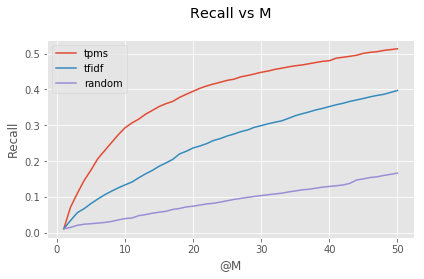

In [13]:
fig, ax = plt.subplots()

ax = graphing.recall_at_m(tpms_avg_scores, ax, 'tpms')
ax = graphing.recall_at_m(tfidf_avg_scores, ax, 'tfidf')
ax = graphing.recall_at_m(random_avg_scores, ax, 'random')

plt.tight_layout()

# filename = 'tpms-tfidf-random-filtered_ranklist'
# fig.savefig("./{0}.png".format(filename), dpi=200)

In [28]:
# Implement MAP or NDCG? 

evaluator = mean_avg_precision.Evaluator(bids_by_forum=bids_by_forum)
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)
print(tfidf_avg_scores)
print(tpms_avg_scores)
print(random_avg_scores)

[0.17879299]
[0.37951483]
[0.05134401]


In [47]:
submission_dir = '../data/uai18/submission_records_fulltext'
reviewer_dir = '../data/uai18/reviewer_archives'

paper_ids = os.listdir(submission_dir)
reviewer_ids = os.listdir(reviewer_dir)

paper_keyphrases_by_id = {}
paper_subj_areas_by_id = {}

for paper_id in paper_ids:
    with open(os.path.join(submission_dir, paper_id)) as f:
        paper_record = f.read() 
        paper_json = json.loads(paper_record) 
        paper_keyphrases_by_id[paper_id.replace('.jsonl', '')] = paper_json['content']['keywords']
#         paper_subj_areas_by_id[paper_id] = paper_json['content']['subject area']

# Get author keyphrases by author id, then compute Jaccard sim matrix based on 
# unigrams, bigrams, sparse bigrams, etc.
reviewer_keyphrases_by_id = {}
reviewer_subj_areas_by_id = {}

for reviewer_id in reviewer_ids:
    reviewer_keyphrases_by_id[reviewer_id.replace('.jsonl', '')] = []
    with open(os.path.join(reviewer_dir, reviewer_id)) as f:
        contents = [json.loads(r.replace('\n',''))['content'] for r in f.readlines()]
        for e in contents:
            if 'keywords' in e.keys():
                reviewer_keyphrases_by_id[reviewer_id.replace('.jsonl', '')].extend(e['keywords'])

In [48]:
reviewer_keyphrases_by_id

{'~Angelika_Kimmig1': [],
 '~Frederic_Sala1': [],
 '~Jirka_Vomlel1': [],
 '~Lloyd_T_Elliott1': [],
 '~Shay_Moran1': [],
 '~Tomas_Werner1': [],
 '~Gerardo_Simari1': [],
 '~Aonan_Zhang1': [],
 '~Jesse_Hostetler1': [],
 '~Arjen_Hommersom1': [],
 '~Ciara_Pike-Burke1': [],
 '~Sara_Magliacane1': [],
 '~Nahla_Ben_Amor1': [],
 '~Tyler_Lu1': [],
 '~Weiwei_Liu1': [],
 '~Hyunjik_Kim1': [],
 '~Jack_Baker1': [],
 '~Tomer_Koren1': [],
 '~Farhad_Anaraki1': [],
 '~Yong_Ren1': [],
 '~Ming_Yuan1': [],
 '~Reza_Babanezhad_Harikandeh1': [],
 '~Siamak_Ravanbakhsh1': ['Deep learning',
  'Unsupervised Learning',
  'Deep learning',
  'Structured prediction',
  'Computer vision',
  'Supervised Learning',
  'Semi-Supervised Learning'],
 '~Y._Samuel_Wang1': [],
 '~Pang_Wei_Koh1': [],
 '~Wei_Ping1': ['convolutional neural network',
  'conditional random field',
  'whole-slide images',
  'histopathology',
  '2000-Speaker Neural TTS',
  'Monotonic Attention',
  'Speech Synthesis'],
 '~Guodong_Zhang1': [],
 '~Junxian

In [45]:
len(reviewer_ids)


253

In [50]:
# Input two sets a and b, return the Jaccard Similarity between them 
def jaccard_sim(a, b):
    return len(a & b) / len(a | b)

In [55]:
scores = []

for reviewer, rev_kps in reviewer_keyphrases_by_id.items():
    if len(rev_kps):
        for paper, paper_kps in paper_keyphrases_by_id.items():
            scores.append((reviewer, paper, jaccard_sim(set(rev_kps), set(paper_kps))))
    
for r, p,s in scores:
     if s > 0:
            print('reviewer: {}, paper: {}, score: {}'.format(r,p,s))

reviewer: ~Siamak_Ravanbakhsh1, paper: ByxCjjxFM, score: 0.1111111111111111
reviewer: ~Siamak_Ravanbakhsh1, paper: r1dGfE1Yz, score: 0.125
reviewer: ~Siamak_Ravanbakhsh1, paper: HyniYVWFM, score: 0.125
reviewer: ~Balaji_Lakshminarayanan1, paper: ByxCjjxFM, score: 0.1
reviewer: ~Balaji_Lakshminarayanan1, paper: rkTb9Q5dM, score: 0.09090909090909091
reviewer: ~Balaji_Lakshminarayanan1, paper: By5DaybYz, score: 0.09090909090909091
reviewer: ~Balaji_Lakshminarayanan1, paper: r1dGfE1Yz, score: 0.1111111111111111
reviewer: ~Balaji_Lakshminarayanan1, paper: HyniYVWFM, score: 0.1111111111111111
reviewer: ~Yan_Liu1, paper: SJNgF7ktz, score: 0.07142857142857142
reviewer: ~Yan_Liu1, paper: BJeo9mJKf, score: 0.07142857142857142
reviewer: ~Yan_Liu1, paper: r1dGfE1Yz, score: 0.08333333333333333
reviewer: ~Yan_Liu1, paper: BJ7bKTJYG, score: 0.07142857142857142
reviewer: ~Yan_Liu1, paper: ByuiOVZFz, score: 0.08333333333333333
reviewer: ~Yan_Liu1, paper: HyniYVWFM, score: 0.08333333333333333
reviewer: 

In [70]:
# Compute MAP
with open(os.path.join(data_dir, 'jaccard_sim_limited_scores.txt'), 'w') as f:
    for r, p, s in scores:
        if s == 0:
            f.write('(\'{}\', \'{}\', {})\n'.format(p, r, 0.01))
        else:
            f.write('(\'{}\', \'{}\', {})\n'.format(p, r, s))
        
jaccard_ranklists = read_scores(os.path.join(data_dir, 'jaccard_sim_limited_scores.txt'))
evaluator = mean_avg_precision.Evaluator(bids_by_forum=bids_by_forum)
jaccard_avg_scores = get_avg_scores(jaccard_ranklists, evaluator)
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)
print(jaccard_avg_scores)
print(tfidf_avg_scores)
print(tpms_avg_scores)
print(random_avg_scores)

[0.04469494]
[0.17879299]
[0.37951483]
[0.05134401]


In [ ]:
# Compute NDCG for all methods

In [ ]:
# Extract keyphrases when not available
